##### Import LHS Sampler

In [1]:
import numpy as np
import pandas as pd
import os
from lhs_sampler import generate_lhs_samples

##### Generate 55 4D samples

In [2]:
bounds = {
    'a': (0.2, 5.0),
    'b': (5, 10), 
    'a_f': (1, 5),
    'b_f': (8, 13)
}

samples = generate_lhs_samples(bounds, n_samples=55)

# allocate the samples to variables
param_a = samples[:, 0]
param_b = samples[:, 1]
param_af = samples[:, 2]
param_bf = samples[:, 3]


##### Simulations

In [3]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
from ufl import cofac

parameters["form_compiler"]["quadrature_degree"] = 2
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"

In [5]:
meshDir = '../HV2/'
meshName = meshDir + 'lvgmsh_mesh.xml'
mfName = meshDir + 'lvgmsh_fmaker.xml'
#print(meshName, mfName)

resultDir = meshDir+'results/'

mesh = Mesh(meshName)
mesh.scale(0.1) # this will scale the mesh unit to be cm
mesh.ufl_cell()

#plot(mesh, edgecolor='k', color="r")

#ax = plt.gca()
#ax.view_init(elev=25, azim=-179)
#plt.show()

fibreName = meshDir+ 'HV2_fibre_dir.xml'
sheetName = meshDir + 'HV2_sheet_dir.xml'
normalName = meshDir + 'HV2_normal_dir.xml'

In [7]:
def load_ellipsoid_data(meshName, mfName, fibreName, sheetName, normalName):
    """Returns 4-tuple:
    mesh - the mesh, 
    mf - MeshFunction defining boundary markers, 
    numbering - dict of marking numbers,
    fibers - list of functions defining microstructure"""

    mesh = Mesh(meshName)
    mesh.scale(0.1) # this will scale the mesh unit to be cm
    mesh.ufl_cell()
                
    mf = MeshFunction("size_t", mesh, mfName)

    numbering = {
        "BASE": 10,
        "ENDO": 30,
        "EPI": 40
    }

    # load fibers, sheet, cross_sheet data 
    fiber_element = VectorElement(family="Lagrange",
                                    cell=mesh.ufl_cell(),
                                    degree=1,
                                    quad_scheme="default")
    fiber_space = FunctionSpace(mesh, fiber_element)
    fiber = Function(fiber_space, fibreName)
    sheet = Function(fiber_space, sheetName)
    cross_sheet = Function(fiber_space, normalName)

    fibers = [fiber,sheet, cross_sheet]
    
    return mesh, mf, numbering, fibers

def compute_cavity_volume(mesh,mf, numbering,u=None):
    X = SpatialCoordinate(mesh) 
    N = FacetNormal(mesh)

    if u is not None:
        I = Identity(3) # the identity matrix
        F = I + grad(u) # the deformation gradient
        J = det(F)
        vol_form = (-1.0/3.0) * dot(X + u, J * inv(F).T * N)
    else:
        vol_form = (-1.0/3.0) * dot(X, N)


    ds = Measure('ds',domain=mesh,subdomain_data=mf)

    return assemble(vol_form*ds(numbering["ENDO"]))

def subplus(x):
    #return dolfin.conditional(dolfin.ge(x, 1), x, 1.0)
    return conditional(ge(x, 1), x, 1.0)

In [8]:
mesh, boundary_markers, numbering, fibers = load_ellipsoid_data(meshName, mfName, 
                                                fibreName, sheetName, normalName)

In [9]:
n_mesh = FacetNormal(mesh)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

#q_degree = 2
#dx = dx(metadata={'quadrature_degree': q_degree})

#Compute_Volume_init()
X = SpatialCoordinate(mesh)
vol = abs(assemble((-1.0/3.0)*dot(X, n_mesh)*ds(numbering['ENDO'])))

print(vol)

73.7313209876846


In [10]:
V = VectorElement("CG", mesh.ufl_cell(), 2)
P = FiniteElement("CG", mesh.ufl_cell(), 1)
TH = V*P
W = FunctionSpace(mesh, TH)

w = Function(W)
(u, p) = split(w)
(du, dp) = TestFunctions(W)

# Kinematics
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
F = variable(F)
C = F.T*F                   # Right Cauchy-Green tensor
B = F*F.T

# Invariants of deformation tensors
I_1 = tr(C)
J = det(F)

# ------------ Original model parameters ------------
"""# Material parameters
alpha =1.0
eta = 0.1   # weighting of transversal fiber tension
rho = Constant(1.0)  # kg
a = 0.280*alpha       # kPa
a_f = 1.1685*alpha    # kPa
a_s = 0.116*alpha       # kPa
a_fs = 1.0*alpha       # kPa
b = 7.780       # dimensionless
b_f = 11.83425   # dimensionless
b_s = 8       # dimensionless
b_fs = 4       # dimensionless"""
# --------------------------------------------

# Changed parameters (55 times for 55 simulations)
alpha =1.0
eta = 0.1   # weighting of transversal fiber tension
rho = Constant(1.0)  # kg
a = param_a[54]*alpha       # kPa
a_f = param_af[54]*alpha    # kPa
a_s = 0.116*alpha       # kPa
a_fs = 1.0*alpha       # kPa
b = param_b[54]       # dimensionless
b_f = param_bf[54]   # dimensionless
b_s = 8       # dimensionless
b_fs = 4       # dimensionless

In [11]:
f_0 = fibers[0]
s_0 = fibers[1]
n_0 = fibers[2]
f = F*f_0
s = F*s_0
n = F*n_0

# Invariants
I_4f = inner(C*f_0,f_0)
I_4s = inner(C*s_0,s_0)
I_4n = inner(C*n_0,n_0)
I8fs = inner(C*f_0, s_0)

# Initial conditions and boundary conditions
boundaries = boundary_markers
zero_displacement = Constant(("0.0", "0.0", "0.0"))
bcr = DirichletBC(W.sub(0), zero_displacement, boundaries, numbering['BASE'])

#zero_zdis = Constant(0.0)
#bcr = DirichletBC(W.sub(0).sub(2), zero_zdis, boundaries, markers['BASE'][0])
#print(W.sub(0).sub(0))
#print(W.sub(0))
#print(W.sub(1))


bcs = [bcr]
p0 = Constant(0); T_a = Constant(0)

# Passive part
passive_cauchy_stress = a*exp(b*(I_1 - 3))*B + 2*a_f*(subplus(I_4f)-1)*exp(b_f*pow( subplus(I_4f) - 1, 2))*outer(f,f) \
                        + 2*a_s*(subplus(I_4s)-1)*exp(b_s*pow( subplus(I_4s) - 1, 2))*outer(s,s)  \
                        + a_fs*I8fs*exp( b_fs*pow(I8fs,2) )*( outer(f,s)+outer(s,f) )  \
                        - p*I
P_p = J*passive_cauchy_stress*inv(F).T

# Active part
active_cauchy_stress = T_a*(outer(f,f)+eta*outer(s,s)+eta*outer(n,n))	
P_a = J*active_cauchy_stress*inv(F.T)

P =  P_p + P_a

eq = inner(P,grad(du))*dx + inner(J-1,dp)*dx + dot(J*inv(F).T*n_mesh*p0, du)*ds(numbering['ENDO']) 
Jac = derivative(eq, w)

In [12]:
ffc_options = {"optimize": True,
               "eliminate_zeros": True,
               "precompute_basis_const": True,
               "precompute_ip_const": True}
form_compiler_parameters = {"keep_diagonal": True}

# in this example we will use a newton scheme to solve the nonlinear problem
newton_solver_parameters = {'absolute_tolerance': 1E-3,
                            'relative_tolerance': 1E-3,
                            'maximum_iterations': 50,
                            'report': True,
                            'error_on_nonconvergence': False,
                            'linear_solver': 'mumps',
                            'preconditioner': 'petsc_amg'}

#'linear_solver': 'mumps'

# the linearized problem is solved using a krylov solver
krylov_solver_parameters = {'absolute_tolerance': 1E-3,
                            'relative_tolerance': 1E-3,
                            'nonzero_initial_guess': True,
                            'error_on_nonconvergence': True,
                            'monitor_convergence': True,
                            'report': True,
                            'divergence_limit': 1E+12}

solver_parameters = {'newton_solver': newton_solver_parameters,
                     'krylov_solver': krylov_solver_parameters,
                     'condition_number': False}



solver = NonlinearVariationalSolver(None)
prm = solver.parameters
# newton solver settings
prm['newton_solver']['convergence_criterion'] = 'incremental'
prm['newton_solver']['absolute_tolerance'] = solver_parameters['newton_solver']['absolute_tolerance']
prm['newton_solver']['relative_tolerance'] = solver_parameters['newton_solver']['relative_tolerance']
prm['newton_solver']['maximum_iterations'] = solver_parameters['newton_solver']['maximum_iterations']
prm['newton_solver']['report'] = solver_parameters['newton_solver']['report']
prm['newton_solver']['error_on_nonconvergence'] = solver_parameters['newton_solver']['error_on_nonconvergence']
prm['newton_solver']['linear_solver'] = solver_parameters['newton_solver']['linear_solver']
#if prm['newton_solver']['linear_solver'] == 'gmres':
#    prm['newton_solver']['preconditioner'] = 'icc'
prm['newton_solver']['krylov_solver']['absolute_tolerance'] = solver_parameters['krylov_solver'][
            'absolute_tolerance']
prm['newton_solver']['krylov_solver']['maximum_iterations'] = 10000
prm['newton_solver']['krylov_solver']['relative_tolerance'] = solver_parameters['krylov_solver'][
            'relative_tolerance']
prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = solver_parameters['krylov_solver'][
            'nonzero_initial_guess']
prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = solver_parameters['krylov_solver'][
            'error_on_nonconvergence']
prm['newton_solver']['krylov_solver']['monitor_convergence'] = solver_parameters['krylov_solver'][
            'monitor_convergence']
prm['newton_solver']['krylov_solver']['report'] = solver_parameters['krylov_solver']['report']
prm['newton_solver']['krylov_solver']['divergence_limit'] = solver_parameters['krylov_solver'][
            'divergence_limit']

In [13]:
total_pressure = 10*133.3/1000.0 #in kPa
steps = 20
volume =  np.zeros(steps+1)
pressure= np.zeros(steps+1)
volume[0] = compute_cavity_volume(mesh,boundary_markers,numbering,u)
pressure[0] = 0.0
#saveFile= File(f"{resultDir}/result.pvd")
   
for i in range(steps):
    print('%i/%i, pressure = %f' % (i+1, steps, total_pressure/steps*(i+1)))
    current_pressure = total_pressure/steps*(i+1) 
    p0.assign(current_pressure)
    T_a.assign(0)
    #solve(eq==0,w,bcs,J=Jac)
    problem = NonlinearVariationalProblem(eq, w, bcs, J=Jac)
    solver = NonlinearVariationalSolver(problem)
    
    prm = solver.parameters
    # newton solver settings
    prm['newton_solver']['convergence_criterion'] = 'incremental'
    prm['newton_solver']['absolute_tolerance'] = solver_parameters['newton_solver']['absolute_tolerance']
    prm['newton_solver']['relative_tolerance'] = solver_parameters['newton_solver']['relative_tolerance']
    prm['newton_solver']['maximum_iterations'] = solver_parameters['newton_solver']['maximum_iterations']
    prm['newton_solver']['report'] = solver_parameters['newton_solver']['report']
    prm['newton_solver']['error_on_nonconvergence'] = solver_parameters['newton_solver']['error_on_nonconvergence']
    prm['newton_solver']['linear_solver'] = solver_parameters['newton_solver']['linear_solver']
    #if prm['newton_solver']['linear_solver'] == 'gmres':
    #    prm['newton_solver']['preconditioner'] = 'icc'
    prm['newton_solver']['krylov_solver']['absolute_tolerance'] = solver_parameters['krylov_solver'][
                'absolute_tolerance']
    prm['newton_solver']['krylov_solver']['maximum_iterations'] = 10000
    prm['newton_solver']['krylov_solver']['relative_tolerance'] = solver_parameters['krylov_solver'][
                'relative_tolerance']
    prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = solver_parameters['krylov_solver'][
                'nonzero_initial_guess']
    prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = solver_parameters['krylov_solver'][
                'error_on_nonconvergence']
    prm['newton_solver']['krylov_solver']['monitor_convergence'] = solver_parameters['krylov_solver'][
                'monitor_convergence']
    prm['newton_solver']['krylov_solver']['report'] = solver_parameters['krylov_solver']['report']
    prm['newton_solver']['krylov_solver']['divergence_limit'] = solver_parameters['krylov_solver'][
                'divergence_limit']

    
    solver.solve()
    
    u = w.split()[0]
    volume[i+1] = compute_cavity_volume(mesh,boundary_markers,numbering,u)
    pressure[i+1] = current_pressure
    # SAVE VOLUME AND PRESSURE
    #u.rename('displacement', 'u')
    #saveFile << (u, float(i) + 1)

1/20, pressure = 0.066650
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.581e+01 (tol = 1.000e-03) r (rel) = 1.000e+00 (tol = 1.000e-03)
  Newton iteration 1: r (abs) = 4.608e+00 (tol = 1.000e-03) r (rel) = 1.006e-01 (tol = 1.000e-03)
  Newton iteration 2: r (abs) = 8.696e-01 (tol = 1.000e-03) r (rel) = 1.898e-02 (tol = 1.000e-03)
  Newton iteration 3: r (abs) = 3.813e-02 (tol = 1.000e-03) r (rel) = 8.323e-04 (tol = 1.000e-03)
  Newton solver finished in 4 iterations and 4 linear solver iterations.
2/20, pressure = 0.133300
3/20, pressure = 0.199950
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.996e+00 (tol = 1.000e-03) r (rel) = 1.000e+00 (tol = 1.000e-03)
  Newton iteration 1: r (abs) = 1.056e+00 (tol = 1.000e-03) r (rel) = 2.113e-01 (tol = 1.000e-03)
  Newton iteration 2: r (abs) = 8.617e-02 (tol = 1.

[0.      0.06665 0.1333  0.19995 0.2666  0.33325 0.3999  0.46655 0.5332
 0.59985 0.6665  0.73315 0.7998  0.86645 0.9331  0.99975 1.0664  1.13305
 1.1997  1.26635 1.333  ]
[ 73.73132099  78.95287201  83.70764425  87.90741871  91.63360736
  94.94567927  97.90114324 100.55165917 102.94062215 105.10623933
 107.08010591 108.88884457 110.55537179 112.09886113 113.53453914
 114.87563231 116.13282964 117.31599702 118.4330664  119.49050933
 120.49412004]


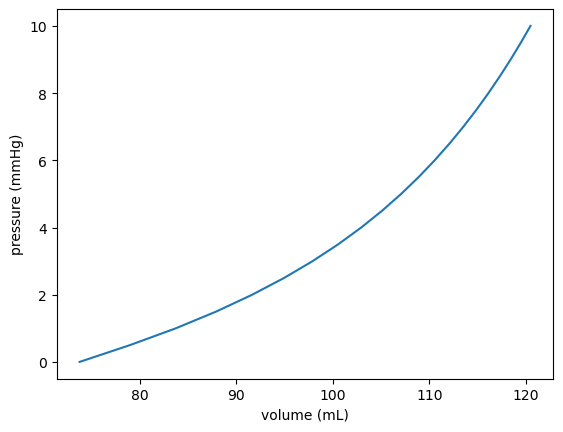

In [14]:
print(pressure)
print(volume)
plt.plot(volume, pressure*1000.0/133.3)
plt.xlabel('volume (mL)')
plt.ylabel('pressure (mmHg)')
plt.show()

In [ ]:
a, b, a_f, b_f, volume[-1]

(4.801712205370671,
 8.937511882408009,
 3.8885112999416234,
 12.954659671203702,
 95.34559116597966)

##### Save data

In [ ]:
results = []

##### Append

In [ ]:
results.append({
    'a': a,
    'b': b,
    'a_f': a_f,
    'b_f': b_f,
    'edv': volume[-1]
})

##### Save df

In [ ]:
df = pd.DataFrame(results)

# Specify folder and filename
folder = "toy_model" / "data" 
filename = "lhs_dataset.csv"

# Ensure the folder exists
os.makedirs(folder, exist_ok=True)

# Full file path
filepath = os.path.join(folder, filename)

# Save as CSV
df.to_csv(filepath, index=False)

print(f"CSV saved to: {filepath}")



CSV saved to: 55_data/lhs_dataset.csv


# Not relevant from this point on

In [ ]:
## project the stress tensor 
# https://fenicsproject.discourse.group/t/how-to-choose-projection-space-for-stress-tensor-post-processing/5568

Vsig = TensorFunctionSpace(mesh, "DG", degree=0) # copied from texts but not understood
sig_num = Function(Vsig, name="Stress Numeric")

u = w.split()[0]
p = w.split()[1]

F = I + grad(u)             # Deformation gradient
F = variable(F)
C = F.T*F                   # Right Cauchy-Green tensor
B = F*F.T

I_1 = tr(C)
J = det(F)

f = F*f_0
s = F*s_0
n = F*n_0

# Invariants
I_4f = inner(C*f_0,f_0)
I_4s = inner(C*s_0,s_0)
I_4n = inner(C*n_0,n_0)
I8fs = inner(C*f_0, s_0)

cauchy_stress = a*exp(b*(I_1 - 3))*B + 2*a_f*(subplus(I_4f)-1)*exp(b_f*pow( subplus(I_4f) - 1, 2))*outer(f,f) \
                        + 2*a_s*(subplus(I_4s)-1)*exp(b_s*pow( subplus(I_4s) - 1, 2))*outer(s,s)  \
                        + a_fs*I8fs*exp( b_fs*pow(I8fs,2) )*( outer(f,s)+outer(s,f) )  \
                        - p*I

sig_num.assign(project(cauchy_stress, Vsig))


P_p = J*passive_cauchy_stress*inv(F).T
eq = inner(P_p,grad(du))*dx + inner(J-1,dp)*dx + dot(J*inv(F).T*n_mesh*p0, du)*ds(numbering['ENDO']) 

In [ ]:
import dolfin
Div_P = dolfin.div(P_p)
Psi_V = inner(Div_P, Div_P)
N = FacetNormal(mesh)
Jump_P_N = dolfin.jump(P, N)
cell_h = dolfin.Constant(mesh.hmin())
Psi_F = dolfin.inner(Jump_P_N, Jump_P_N)/cell_h
dF = dolfin.Measure('dS', mesh)
Psi_F_energy = assemble(Psi_F*dF)
DivP_energy = assemble(Psi_V*dx)

print(DivP_energy+Psi_F_energy)


Calling FFC just-in-time (JIT) compiler, this may take some time.
9573.261122129548


In [ ]:
# figure the equation that is being solved, the loading pressure is weakly enforced, seems not point-wise equal
eq = inner(P_p,grad(u))*dx + inner(J-1,p)*dx + dot(J*inv(F).T*n_mesh*p0, u)*ds(numbering['ENDO']) 
eq_internal = inner(P_p,grad(u))*dx + inner(J-1,p)*dx 
eq_external = dot(J*inv(F).T*n_mesh*p0, u)*ds(numbering['ENDO'])
total_eq = assemble(eq)
total_eq_internal = assemble(eq_internal)
total_eq_external = assemble(eq_external)
print(total_eq, total_eq_internal, total_eq_external)

Calling FFC just-in-time (JIT) compiler, this may take some time.
2.1625487511833796e-10 104.07190830027724 -104.07190830006273


In [ ]:
# trying to say what is the value of stress projection on the endo surface 
# https://fenicsproject.discourse.group/t/why-is-the-normal-stress-non-zero-at-boundary-where-i-impose-zero-normal-stress/5193
V = VectorFunctionSpace(mesh, "CG", 1)
u_int = project(u, V)
deformed_mesh = Mesh(mesh)
ALE.move(deformed_mesh, u_int)
n_mesh_def = FacetNormal(deformed_mesh)

endo_area = assemble(1*ds(numbering['ENDO']))
print(endo_area)

P_p = J*cauchy_stress*inv(F).T

stress_nor = dot(P_p*n_mesh, n_mesh)*ds(numbering['ENDO']) #now need to figure out the right value of first PK
total_stress_nor = assemble(stress_nor)

p_nor = dot( -J*p0*inv(F).T*n_mesh, n_mesh)*ds(numbering['ENDO'])
#p_nor = J*p0*ds(numbering['ENDO'])
total_p_nor = assemble(p_nor)

print(total_stress_nor/endo_area)
print(total_p_nor/endo_area)



#VsigNor = FunctionSpace(mesh, "DG") 
#sig_nor = Function(VsigNor, 'normal stress')
#sig_nor.assign(project(stress_nor, VsigNor))



#stressNorm = Function(U, name="StressNorm")
#stressNorm.assign(project(stress_nor),U)
#fileResults.write(stressNorm,0.)

82.59033627721838
-0.3028745842751896
-1.9441558599159159


In [ ]:
dFE = FiniteElement("DG", deformed_mesh.ufl_cell(), 0)
FE = FiniteElement("Lagrange",  mesh.ufl_cell() ,1)
vFE = VectorElement(FE)
tFE = TensorElement(dFE)
fileResults = XDMFFile(resultDir+"output.xdmf")
fileResults.parameters["flush_output"] = True
fileResults.parameters["functions_share_mesh"] = True

U = FunctionSpace(mesh, dFE)
V = FunctionSpace(mesh, vFE)
W = FunctionSpace(mesh, tFE)

stress = Function(W, name='Stress')
stress.assign(project(cauchy_stress, W))
fileResults.write(stress,0.)

In [ ]:
## Fenics does not work with new version of Matplotlib for showing the mesh in jupyter
## skip it for now

# Plot the deformed cube and the original
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (20,10))
# Plot the result on to of the original
#axes1 = fig.add_subplot(projection = '3d')

V = VectorFunctionSpace(mesh, "CG", 1)
u_int = project(u, V)
deformed_mesh = Mesh(mesh)
ALE.move(deformed_mesh, u_int)


#plot(deformed_mesh, alpha=0.1, edgecolor='k', color='w')
#plot(mesh, color="r")

#ax = plt.gca()
#ax.view_init(elev=25, azim=-179)
#ax.set_axis_on()
plt.show()


#mesh_file = dolfin.File(f"{save_dir}/lv_deformed.pvd")
#mesh_file << deformed_mesh

<Figure size 2000x1000 with 0 Axes>